In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


In [2]:
import os
import shutil

source_dir = "/kaggle/input/face-mask-detection"
destination_dir = "/content/face-mask-detection"

# Create the destination directory if it doesn't exist, or if it does, allow overwriting
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Copied contents from {source_dir} to {destination_dir}")

Copied contents from /kaggle/input/face-mask-detection to /content/face-mask-detection


In [3]:
#%pip install tensorflow##
%pip install opencv-python

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [5]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [6]:
import os

annotations_dir = "/content/face-mask-detection/annotations"
images_dir = "/content/face-mask-detection/images"

num_annotations = len(os.listdir(annotations_dir))
num_images = len(os.listdir(images_dir))

print(f"Number of files in {annotations_dir}: {num_annotations}")
print(f"Number of files in {images_dir}: {num_images}")

Number of files in /content/face-mask-detection/annotations: 853
Number of files in /content/face-mask-detection/images: 853


In [7]:
import xml.etree.ElementTree as ET
import shutil
from collections import defaultdict

def parse_xml_annotations(annotations_dir):
    """
    Parse PASCAL VOC format XML annotations
    Returns a dictionary with image info and bounding boxes
    """
    annotations = []

    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Get image info
            filename = root.find('filename').text

            # Get all objects in the image
            objects = []
            for obj in root.findall('object'):
                class_name = obj.find('name').text

                # Get bounding box coordinates
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                objects.append({
                    'class': class_name,
                    'bbox': [xmin, ymin, xmax, ymax]
                })

            annotations.append({
                'filename': filename,
                'objects': objects
            })

    return annotations

# Parse annotations
print("Parsing XML annotations...")
annotations = parse_xml_annotations('/content/face-mask-detection/annotations')
print(f"Found {len(annotations)} annotated images")

Parsing XML annotations...
Found 853 annotated images


In [8]:
class_counts = defaultdict(int)
image_class_summary = {}

for ann in annotations:
    filename = ann['filename']
    classes_in_image = [obj['class'] for obj in ann['objects']]

    # Count all classes
    for cls in classes_in_image:
        class_counts[cls] += 1

    # Determine overall image class (for classification)
    # Priority: with_mask > without_mask > mask_weared_incorrect
    if 'with_mask' in classes_in_image:
        image_class_summary[filename] = 'with_mask'
    elif 'without_mask' in classes_in_image:
        image_class_summary[filename] = 'without_mask'
    else:
        image_class_summary[filename] = 'mask_weared_incorrect'

print(f"\nClass distribution in bounding boxes:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print(f"\nImage-level class distribution:")
image_class_counts = defaultdict(int)
for cls in image_class_summary.values():
    image_class_counts[cls] += 1

for cls, count in image_class_counts.items():
    print(f"{cls}: {count}")



Class distribution in bounding boxes:
with_mask: 3232
without_mask: 717
mask_weared_incorrect: 123

Image-level class distribution:
with_mask: 768
without_mask: 64
mask_weared_incorrect: 21


In [9]:
# 4. Data Organization for Classification
# Create directories for organized data

print("\nCreating directory structure...")
os.makedirs('dataset/train/with_mask', exist_ok=True)
os.makedirs('dataset/train/without_mask', exist_ok=True)
os.makedirs('dataset/validation/with_mask', exist_ok=True)
os.makedirs('dataset/validation/without_mask', exist_ok=True)
os.makedirs('dataset/test/with_mask', exist_ok=True)
os.makedirs('dataset/test/without_mask', exist_ok=True)


Creating directory structure...


In [10]:
def organize_images_from_annotations():
    """
    Organize images based on parsed XML annotations
    """
    from sklearn.model_selection import train_test_split

    # Filter out images for binary classification
    # Option 1: Only use with_mask and without_mask
    filtered_images = {}
    for filename, cls in image_class_summary.items():
        if cls in ['with_mask', 'without_mask']:
            filtered_images[filename] = cls
        # Option 2: Treat mask_weared_incorrect as without_mask
        elif cls == 'mask_weared_incorrect':
            filtered_images[filename] = 'without_mask'  # Change this if you want to exclude these images

    # Convert to lists for train_test_split
    filenames = list(filtered_images.keys())
    labels = list(filtered_images.values())

    print(f"\nUsing {len(filenames)} images for classification")
    print(f"Final class distribution:")
    final_counts = defaultdict(int)
    for label in labels:
        final_counts[label] += 1
    for cls, count in final_counts.items():
        print(f"{cls}: {count}")

    # Split data (70% train, 20% validation, 10% test)
    train_files, test_files, train_labels, test_labels = train_test_split(
        filenames, labels, test_size=0.1, stratify=labels, random_state=42
    )

    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.22, stratify=train_labels, random_state=42
    )

    # Copy files to respective directories
    splits = [
        (train_files, train_labels, 'train'),
        (val_files, val_labels, 'validation'),
        (test_files, test_labels, 'test')
    ]

    for files, labels, split_name in splits:
        print(f"\nOrganizing {split_name} set...")
        for filename, label in zip(files, labels):
            src_path = os.path.join('/content/face-mask-detection/images', filename)
            dest_path = f'dataset/{split_name}/{label}/{filename}'

            if os.path.exists(src_path):
                shutil.copy2(src_path, dest_path)
                print(f"Copied {filename} to {split_name}/{label}/")
            else:
                print(f"Warning: {src_path} not found!")


In [11]:
organize_images_from_annotations()



Using 853 images for classification
Final class distribution:
with_mask: 768
without_mask: 85

Organizing train set...
Copied maksssksksss843.png to train/with_mask/
Copied maksssksksss370.png to train/without_mask/
Copied maksssksksss91.png to train/with_mask/
Copied maksssksksss594.png to train/with_mask/
Copied maksssksksss212.png to train/with_mask/
Copied maksssksksss89.png to train/with_mask/
Copied maksssksksss33.png to train/with_mask/
Copied maksssksksss616.png to train/with_mask/
Copied maksssksksss759.png to train/with_mask/
Copied maksssksksss265.png to train/with_mask/
Copied maksssksksss281.png to train/with_mask/
Copied maksssksksss795.png to train/with_mask/
Copied maksssksksss297.png to train/with_mask/
Copied maksssksksss318.png to train/with_mask/
Copied maksssksksss647.png to train/with_mask/
Copied maksssksksss364.png to train/with_mask/
Copied maksssksksss226.png to train/with_mask/
Copied maksssksksss394.png to train/with_mask/
Copied maksssksksss562.png to trai

In [12]:
# Optional: Function to crop faces using bounding boxes (for better accuracy)
def crop_faces_from_annotations():
    """
    Optional: Crop face regions using bounding boxes for better classification
    This can improve model performance by focusing on the face region
    """
    import cv2

    os.makedirs('dataset_cropped/train/with_mask', exist_ok=True)
    os.makedirs('dataset_cropped/train/without_mask', exist_ok=True)
    os.makedirs('dataset_cropped/validation/with_mask', exist_ok=True)
    os.makedirs('dataset_cropped/validation/without_mask', exist_ok=True)
    os.makedirs('dataset_cropped/test/with_mask', exist_ok=True)
    os.makedirs('dataset_cropped/test/without_mask', exist_ok=True)

    for ann in annotations:
        filename = ann['filename']
        if filename not in image_class_summary:
            continue

        img_class = image_class_summary[filename]
        if img_class not in ['with_mask', 'without_mask']:
            if img_class == 'mask_weared_incorrect':
                img_class = 'without_mask'  # Treat as without_mask
            else:
                continue

        # Load image
        img_path = os.path.join('/content/face-mask-detection/images', filename)
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        # Process each face in the image
        for i, obj in enumerate(ann['objects']):
            if obj['class'] in ['with_mask', 'without_mask', 'mask_weared_incorrect']:
                xmin, ymin, xmax, ymax = obj['bbox']

                # Add some padding around the face
                padding = 20
                h, w = img.shape[:2]
                xmin = max(0, xmin - padding)
                ymin = max(0, ymin - padding)
                xmax = min(w, xmax + padding)
                ymax = min(h, ymax + padding)

                # Crop the face
                face_crop = img[ymin:ymax, xmin:xmax]

                # Save cropped face
                base_name = os.path.splitext(filename)[0]
                crop_filename = f"{base_name}_face_{i}.jpg"

                # Determine split (you'd need to implement this logic)
                # For now, saving all to train
                crop_path = f'dataset_cropped/train/{img_class}/{crop_filename}'
                cv2.imwrite(crop_path, face_crop)


In [13]:
print("\nDataset organization completed!")
print("Choose one of the following:")
print("1. Use full images (recommended for transfer learning)")
print("2. Uncomment crop_faces_from_annotations() to use cropped faces")
# crop_faces_from_annotations()  # Uncomment if you want to use cropped faces


Dataset organization completed!
Choose one of the following:
1. Use full images (recommended for transfer learning)
2. Uncomment crop_faces_from_annotations() to use cropped faces


In [14]:
import os

def count_files_in_directory(directory):
    """Counts the number of files in a directory, including subdirectories."""
    file_count = 0
    for root, _, files in os.walk(directory):
        file_count += len(files)
    return file_count

dataset_directory = "/content/dataset"
num_files_in_dataset = count_files_in_directory(dataset_directory)

print(f"Number of files in {dataset_directory} (including subdirectories): {num_files_in_dataset}")

Number of files in /content/dataset (including subdirectories): 853


In [15]:
# 5. Image Data Generators with Augmentation
IMG_SIZE = 224  # EfficientNetB3 input size
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation and test data generators (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")


Found 598 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Training samples: 598
Validation samples: 169
Test samples: 86
Class indices: {'with_mask': 0, 'without_mask': 1}


In [16]:
# 6. Build the Model with EfficientNetB3
def create_model():
    # Load EfficientNetB3 pre-trained model
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', name='predictions')(x)  # 2 classes: with_mask, without_mask

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

model, base_model = create_model()
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,980,529 (41.89 MB)

 Trainable params: 196,994 (769.51 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [17]:
# 7. Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# 8. Setup Callbacks
callbacks = [
    ModelCheckpoint(
        'best_face_mask_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [19]:
# 9. Train the Model (Phase 1: Frozen base model)
print("Phase 1: Training with frozen base model...")
EPOCHS_PHASE1 = 15

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Phase 1: Training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8289 - loss: 0.4625
Epoch 1: val_accuracy improved from -inf to 0.89941, saving model to best_face_mask_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 172s 8s/step - accuracy: 0.8315 - loss: 0.4601 - val_accuracy: 0.8994 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8881 - loss: 0.3616
Epoch 2: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 150s 8s/step - accuracy: 0.8887 - loss: 0.3600 - val_accuracy: 0.8994 - val_loss: 0.3237 - learning_rate: 0.0010
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8889 - loss: 0.3663
Epoch 3: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.8895 - loss: 0.3647 - val_accuracy: 0.8994 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9103 - loss: 0.3143
Epoch 4: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.9098 - loss: 0.3155 - val_accuracy: 0.8994 - val_loss: 0.3235 - learning_rate: 0.0010
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
# 10. Fine-tuning (Phase 2: Unfreeze some layers)
print("\nPhase 2: Fine-tuning with unfrozen layers...")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune from the top layers
fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Phase 2: Fine-tuning with unfrozen layers...


In [21]:
EPOCHS_PHASE2 = 10
total_epochs = EPOCHS_PHASE1 + EPOCHS_PHASE2

history_phase2 = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=len(history_phase1.history['loss']),
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 16/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5121 - loss: 1.5213
Epoch 16: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.5230 - loss: 1.4863 - val_accuracy: 0.8994 - val_loss: 0.3237 - learning_rate: 1.0000e-04
Epoch 17/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8943 - loss: 0.3894
Epoch 17: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.8947 - loss: 0.3878 - val_accuracy: 0.8994 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 18/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9061 - loss: 0.3224
Epoch 18: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.9058 - loss: 0.3230 - val_accuracy: 0.8994 - val_loss: 0.3400 - learning_rate: 1.0000e-04
Epoch 19/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8958 - loss: 0.3488
Epoch 19: val_accuracy did not improve from 0.89941
19/19 ━━━━━━━━━━━━━━━━━━

In [22]:
# 12. Evaluate the Model
# Load the best model
model.load_weights('best_face_mask_model.h5')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8953
Test Loss: 0.3449


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.90      1.00      0.94        77
without_mask       0.00      0.00      0.00         9

    accuracy                           0.90        86
   macro avg       0.45      0.50      0.47        86
weighted avg       0.80      0.90      0.85        86



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


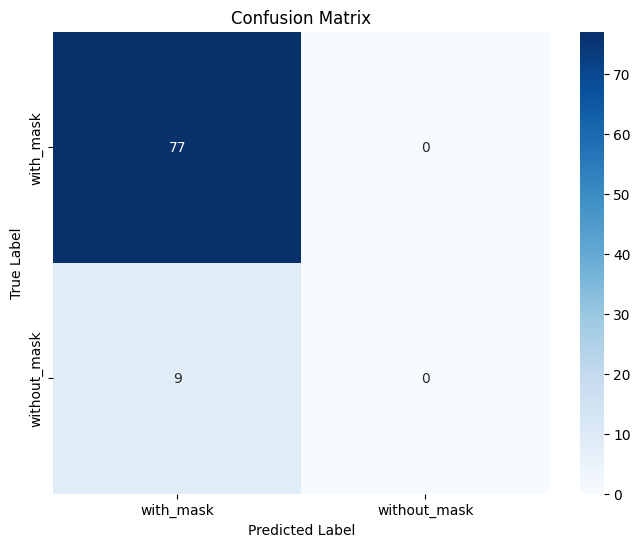

In [23]:
# 13. Detailed Evaluation with Classification Report
# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [24]:
# 15. Save the Final Model
model.save('face_mask_detection_efficientnetb3.h5')
print("Model saved as 'face_mask_detection_efficientnetb3.h5'")


Model saved as 'face_mask_detection_efficientnetb3.h5'


In [25]:
def predict_mask(image_path):
    """
    Predict if a person in the image is wearing a mask or not
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    prediction = model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]

    # Get class name
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[predicted_class_idx]

    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}')
    plt.show()

    return predicted_class, confidence

In [26]:
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Architecture: EfficientNetB3 + Custom Head")
print(f"Input Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training completed successfully!")
print("="*50)


MODEL SUMMARY
Architecture: EfficientNetB3 + Custom Head
Input Size: 224x224
Total Parameters: 10,980,529
Test Accuracy: 0.8953
Training completed successfully!


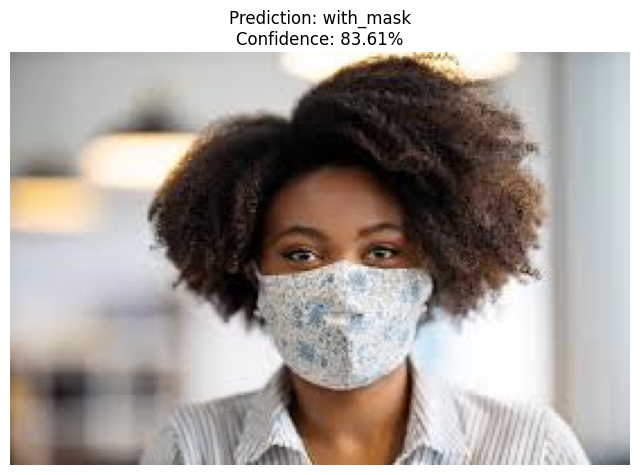

('with_mask', np.float32(0.8361429))

In [27]:
#Example usage (uncomment to use with an actual image):
predict_mask('/content/masked.jpg')